# Notebook 3: Model Training

## Objectives
- Prepare final dataset (OHE, Scaling, Split)
- Handle class imbalance using SMOTE
- Train Logistic Regression, Random Forest, and XGBoost
- Perform Hyperparameter Tuning
- Evaluate and select best model
- Save the best model

In [1]:
import pandas as pd
import numpy as np
import sys
import os

sys.path.append(os.path.abspath(os.path.join('../src')))

from data_preprocessing import preprocess_pipeline
from feature_engineering import engineer_all_features
from model_training import train_all_models, save_model
from model_evaluation import evaluate_model, plot_confusion_matrix, plot_roc_curve, plot_feature_importance, calculate_business_metrics
from data_preprocessing import load_data, clean_data # Helper to load raw for FE step first

pd.set_option('display.max_columns', None)

## 1. Prepare Data
We first load, clean, and engineer features. Then we pass it to the preprocessing pipeline.

In [2]:
filepath = '../data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

if os.path.exists(filepath):
    # 1. Load & Clean
    df = load_data(filepath)
    df = clean_data(df)
    
    # 2. Engineer Features
    df = engineer_all_features(df)
    
    # 3. Preprocessing (split, OHE, scale)
    # Note: preprocess_pipeline expects raw file path usually, but we modified df in memory.
    # We need to adapt preprocess_pipeline or standard logic here.
    # For simplicity, let's replicate the pipeline steps manually here or use the function if adapted.
    # The provided function takes filepath. We will just overwrite the file temporarily or (better) 
    # just use the logic from the pipeline on our in-memory DF.
    
    # REUSE LOGIC directly (copy-paste style or meaningful usage)
    # Let's rely on standard sklearn split here since we have the dataframe DF ready.
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    X = df.drop(['Churn', 'tenure_group'], axis=1) # Drop target and non-numeric categ meant for analysis
    y = df['Churn']
    
    # OHE
    X = pd.get_dummies(X, drop_first=True)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale
    scaler = StandardScaler()
    cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges', 'CLV', 'ServiceCount', 'MonthlyCharges_per_Tenure']
    cols_to_scale = [c for c in cols_to_scale if c in X_train.columns]
    
    X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
    X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
    
    features = X_train.columns.tolist()
    print("Data prepared. Train shape:", X_train.shape)
else:
    print("Data file not found.")

2026-01-13 16:34:51,116 - INFO - Loading data from ../data/WA_Fn-UseC_-Telco-Customer-Churn.csv
2026-01-13 16:34:51,170 - INFO - Data loaded successfully with shape (7043, 21)
2026-01-13 16:34:51,171 - INFO - Starting data cleaning...
2026-01-13 16:34:51,187 - INFO - Found 11 missing values in TotalCharges. Filling with 0.
2026-01-13 16:34:51,222 - INFO - Data cleaning completed.
2026-01-13 16:34:51,223 - INFO - Starting feature engineering pipeline...
2026-01-13 16:34:51,230 - INFO - Creating tenure groups...
2026-01-13 16:34:51,241 - INFO - Calculating CLV...
2026-01-13 16:34:51,245 - INFO - Creating ServiceCount feature...
2026-01-13 16:34:51,294 - INFO - Creating interaction features...
2026-01-13 16:34:51,296 - INFO - Feature engineering pipeline completed.


Data prepared. Train shape: (5634, 33)


## 2. Train Models

In [3]:
if 'X_train' in locals():
    # Train all models with SMOTE enabled
    results = train_all_models(X_train, y_train, use_smote=True, tune_hyperparameters=True)
    
    print("\nBest Model selected:", results['best_model_name'])

2026-01-13 16:34:51,359 - INFO - Training LogisticRegression...
2026-01-13 16:34:51,361 - INFO - Tuning hyperparameters for LogisticRegression...


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END classifier__C=0.1, classifier__penalty=l2;, score=0.837 total time=   0.1s
[CV 2/5] END classifier__C=0.1, classifier__penalty=l2;, score=0.822 total time=   0.0s
[CV 3/5] END classifier__C=0.1, classifier__penalty=l2;, score=0.840 total time=   0.0s
[CV 4/5] END classifier__C=0.1, classifier__penalty=l2;, score=0.860 total time=   0.0s
[CV 5/5] END classifier__C=0.1, classifier__penalty=l2;, score=0.848 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__penalty=l2;, score=0.836 total time=   0.1s
[CV 2/5] END classifier__C=1, classifier__penalty=l2;, score=0.822 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__penalty=l2;, score=0.841 total time=   0.1s
[CV 4/5] END classifier__C=1, classifier__penalty=l2;, score=0.860 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__penalty=l2;, score=0.849 total time=   0.0s
[CV 1/5] END classifier__C=10, classifier__penalty=l2;, score=0.836 to

2026-01-13 16:34:53,835 - INFO - Best params for LogisticRegression: {'classifier__C': 10, 'classifier__penalty': 'l2'}
2026-01-13 16:34:53,836 - INFO - Best CV ROC-AUC for LogisticRegression: 0.8417
2026-01-13 16:34:53,837 - INFO - Training RandomForest...
2026-01-13 16:34:53,839 - INFO - Tuning hyperparameters for RandomForest...


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.832 total time=   2.0s
[CV 2/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.817 total time=   2.2s
[CV 3/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.835 total time=   2.0s
[CV 4/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.850 total time=   2.1s
[CV 5/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.847 total time=   2.1s
[CV 1/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classi

2026-01-13 16:37:16,430 - INFO - Best params for RandomForest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
2026-01-13 16:37:16,432 - INFO - Best CV ROC-AUC for RandomForest: 0.8373
2026-01-13 16:37:16,435 - INFO - Training XGBoost...
2026-01-13 16:37:16,437 - INFO - Tuning hyperparameters for XGBoost...


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.8;, score=0.839 total time=   0.4s
[CV 2/5] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.8;, score=0.828 total time=   0.2s
[CV 3/5] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.8;, score=0.838 total time=   0.2s
[CV 4/5] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.8;, score=0.860 total time=   0.2s
[CV 5/5] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.8;, score=0.847

2026-01-13 16:37:25,231 - INFO - Best params for XGBoost: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
2026-01-13 16:37:25,231 - INFO - Best CV ROC-AUC for XGBoost: 0.8422



Best Model selected: XGBoost


## 3. Model Evaluation

2026-01-13 16:37:25,246 - INFO - Evaluating XGBoost...
2026-01-13 16:37:25,297 - INFO - XGBoost Performance:
2026-01-13 16:37:25,298 - INFO - Accuracy: 0.7516, Precision: 0.5222, Recall: 0.7540, F1: 0.6171, AUC: 0.8409297579374306


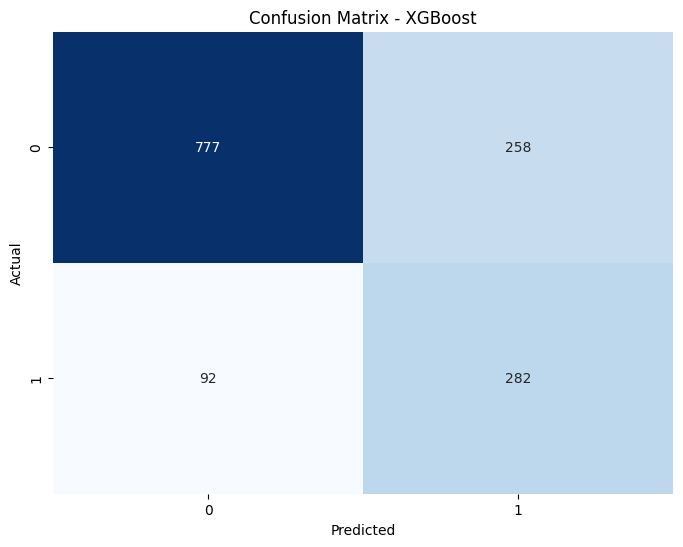

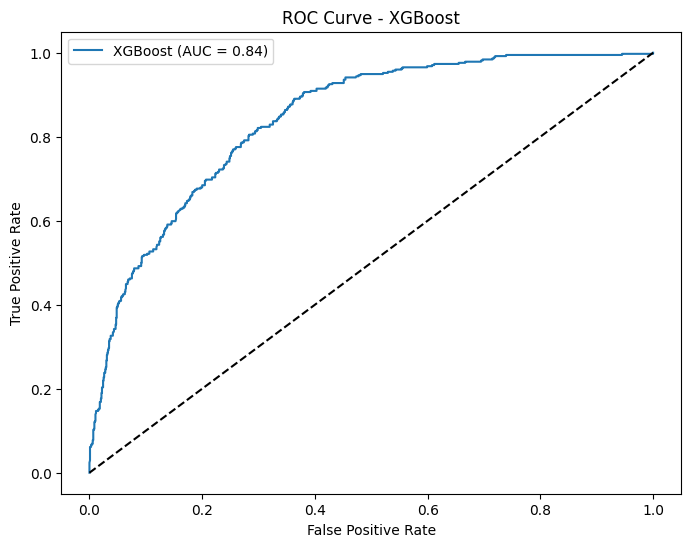

C:\Users\poorv\OneDrive\Desktop\customer_churn_prediction\src\model_evaluation.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')


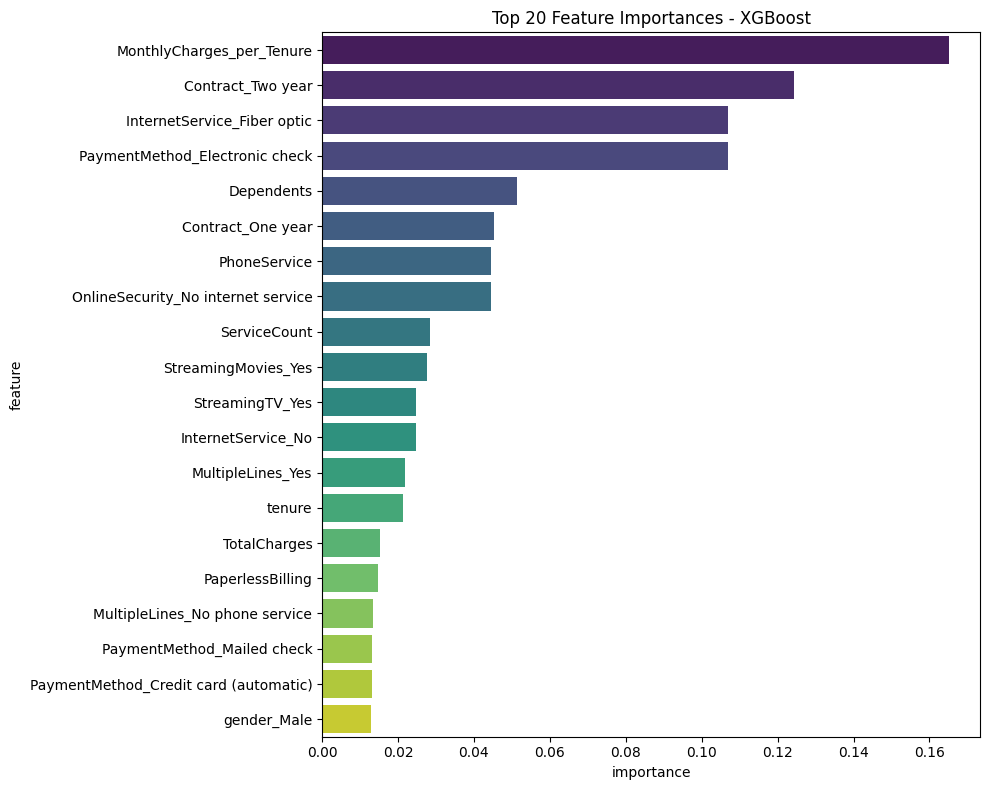

In [4]:
if 'results' in locals() and results.get('best_model_name'):
    best_name = results['best_model_name']
    best_model_info = results[best_name]
    best_model = best_model_info['model']
    
    # Evaluate
    metrics = evaluate_model(best_model, X_test, y_test, best_name)
    
    # Visualizations
    plot_confusion_matrix(y_test, metrics['y_pred'], best_name)
    plot_roc_curve(y_test, metrics['y_prob'], best_name)
    plot_feature_importance(best_model, features, best_name)

## 4. Business Metrics

In [5]:
if 'metrics' in locals():
    biz_metrics = calculate_business_metrics(metrics, y_test)
    print("Estimated Revenue Saved:", f"${biz_metrics['revenue_saved']:,.2f}")
    print("Wasted Budget on False Alarms:", f"${biz_metrics['wasted_budget']:,.2f}")
    print("Net Benefit:", f"${biz_metrics['net_benefit']:,.2f}")

Estimated Revenue Saved: $104,340.00
Wasted Budget on False Alarms: $25,800.00
Net Benefit: $78,540.00


## 5. Save Model

In [6]:
if 'best_model' in locals():
    save_path = '../models/best_model.pkl'
    if not os.path.exists('../models'):
        os.makedirs('../models')
    save_model(best_model, save_path, features)
    print(f"Model saved to {save_path}")

2026-01-13 16:37:27,012 - INFO - Model saved to ../models/best_model.pkl


Model saved to ../models/best_model.pkl
